In [ ]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
from picosdk.ps2000a import ps2000a as ps
from picosdk.functions import adc2mV, assert_pico_ok

# === USER INPUT ===
temperature = input("Enter temperature in Celsius: ").strip()

# === SETTINGS ===
voltage_range_mv = 2000        # ±2V input range
timebase = 1                   # 2 ns/sample (500 MS/s)
samples_per_capture = 1000     # ~2 µs window
acquisition_duration_s = 10    # seconds per threshold
pulse_dead_time_ns = 20        # Minimum spacing between pulses (ns)
thresholds_mv = np.arange(100, 801, 15)  # Threshold sweep: 100–800 mV

# === PICO INITIALIZE ===
chandle = ctypes.c_int16()
assert_pico_ok(ps.ps2000aOpenUnit(ctypes.byref(chandle), None))

channel = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']
coupling = ps.PS2000A_COUPLING['PS2000A_DC']
range_code = ps.PS2000A_RANGE['PS2000A_2V']
assert_pico_ok(ps.ps2000aSetChannel(chandle, channel, 1, coupling, range_code, 0.0))

max_adc = ctypes.c_int16()
assert_pico_ok(ps.ps2000aMaximumValue(chandle, ctypes.byref(max_adc)))

# === TIMEBASE INFO ===
time_interval_ns = ctypes.c_float()
returned_max_samples = ctypes.c_int32()
assert_pico_ok(ps.ps2000aGetTimebase2(
    chandle, timebase, samples_per_capture,
    ctypes.byref(time_interval_ns), 0,
    ctypes.byref(returned_max_samples), 0
))
sample_interval_ns = time_interval_ns.value
dead_time_samples = int(pulse_dead_time_ns / sample_interval_ns)

# === OUTPUT FILE ===
output_file = f'dcr_vs_threshold_T{temperature}C.csv'
csv_file = open(output_file, 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Threshold_mV', 'DCR_Hz', 'Temperature_C'])

# === THRESHOLD LOOP ===
try:
    print(f"\nMeasuring DCR vs Threshold at {temperature} °C...\n")
    for threshold_mv in thresholds_mv:
        print(f"\n→ Threshold = {threshold_mv} mV")

        pulse_count = 0
        start_time = time.time()

        while time.time() - start_time < acquisition_duration_s:
            buffer = (ctypes.c_int16 * samples_per_capture)()
            ps.ps2000aSetDataBuffers(chandle, channel, buffer, None, samples_per_capture, 0, 0)

            ps.ps2000aRunBlock(chandle, 0, samples_per_capture, timebase, 0, None, 0, None, None)

            ready = ctypes.c_int16(0)
            while not ready.value:
                ps.ps2000aIsReady(chandle, ctypes.byref(ready))
                time.sleep(0.001)

            c_samples = ctypes.c_int32(samples_per_capture)
            overflow = ctypes.c_int16()
            ps.ps2000aGetValues(chandle, 0, ctypes.byref(c_samples), 0, 0, 0, ctypes.byref(overflow))

            voltage_mv = adc2mV(buffer, range_code, max_adc)

            last_pulse_index = -dead_time_samples
            for i in range(len(voltage_mv)):
                if voltage_mv[i] >= threshold_mv and (i - last_pulse_index >= dead_time_samples):
                    pulse_count += 1
                    last_pulse_index = i

            ps.ps2000aStop(chandle)

        elapsed_time = time.time() - start_time
        dcr = pulse_count / elapsed_time
        print(f"   → Pulses: {pulse_count}, Time: {elapsed_time:.2f} s, DCR: {dcr:.2f} Hz")

        csv_writer.writerow([threshold_mv, f"{dcr:.2f}", temperature])

finally:
    ps.ps2000aCloseUnit(chandle)
    csv_file.close()

# === PLOT RESULTS ===
# Reload data for plotting
thresholds = []
dcrs = []
with open(output_file, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        thresholds.append(float(row['Threshold_mV']))
        dcrs.append(float(row['DCR_Hz']))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, dcrs, marker='o')
plt.title(f"DCR vs Threshold at {temperature} °C")
plt.xlabel("Threshold (mV)")
plt.ylabel("Dark Count Rate (Hz)")
plt.grid(True)
plt.tight_layout()
plt.savefig(f'dcr_vs_threshold_T{temperature}C.png')
plt.show()


Time interval: 4.00 ns/sample
Capturing pulse 1/100000...
Capturing pulse 2/100000...
Capturing pulse 3/100000...
Capturing pulse 4/100000...
Capturing pulse 5/100000...
Capturing pulse 6/100000...
Capturing pulse 7/100000...
Capturing pulse 8/100000...
Capturing pulse 9/100000...
Capturing pulse 10/100000...
Capturing pulse 11/100000...
Capturing pulse 12/100000...
Capturing pulse 13/100000...
Capturing pulse 14/100000...
Capturing pulse 15/100000...
Capturing pulse 16/100000...
Capturing pulse 17/100000...
Capturing pulse 18/100000...
Capturing pulse 19/100000...
Capturing pulse 20/100000...
Capturing pulse 21/100000...
Capturing pulse 22/100000...
Capturing pulse 23/100000...
Capturing pulse 24/100000...
Capturing pulse 25/100000...
Capturing pulse 26/100000...
Capturing pulse 27/100000...
Capturing pulse 28/100000...
Capturing pulse 29/100000...
Capturing pulse 30/100000...
Capturing pulse 31/100000...
Capturing pulse 32/100000...
Capturing pulse 33/100000...
Capturing pulse 34/100

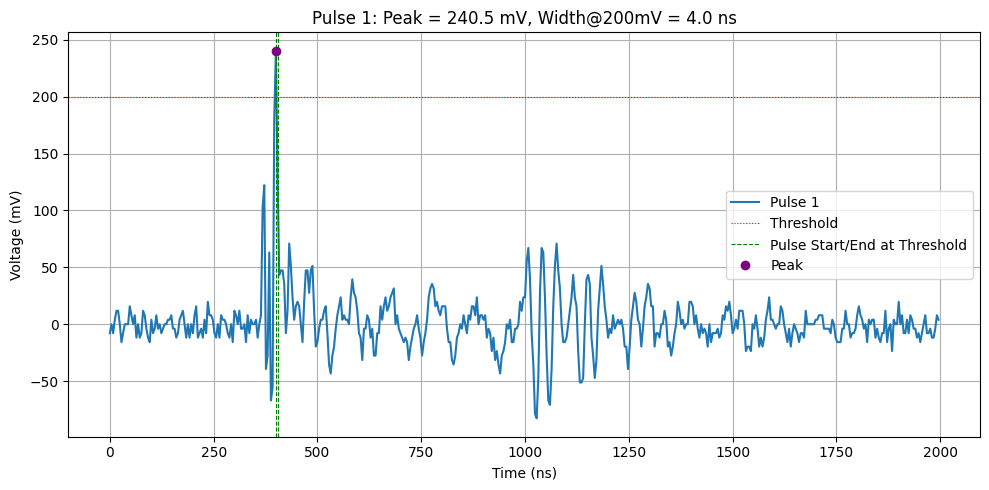

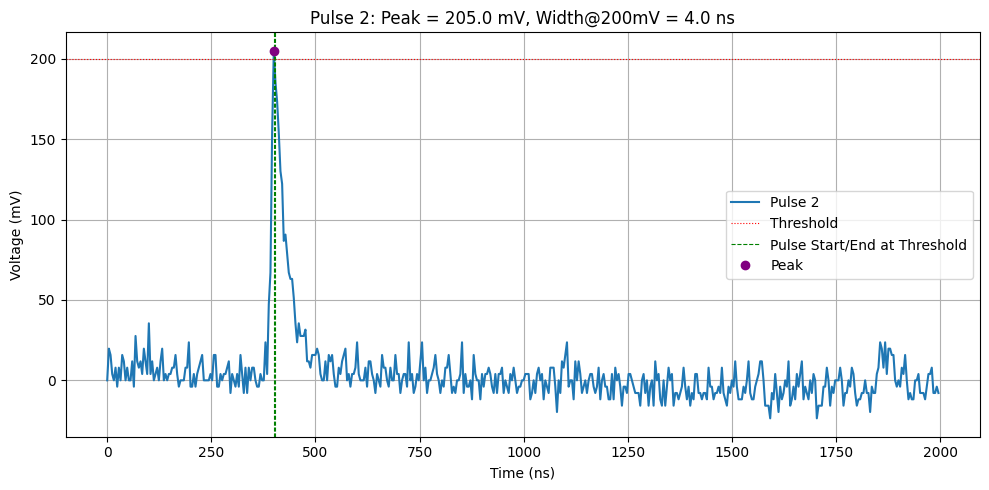

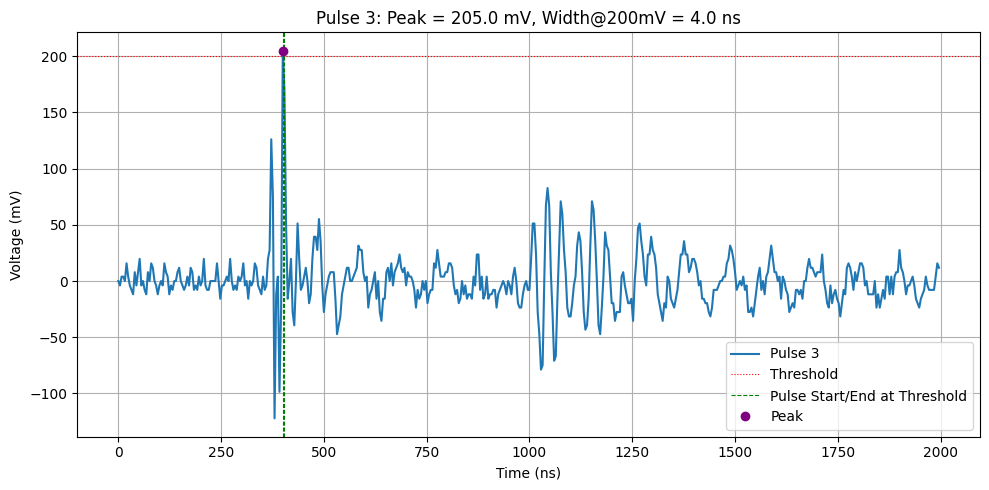

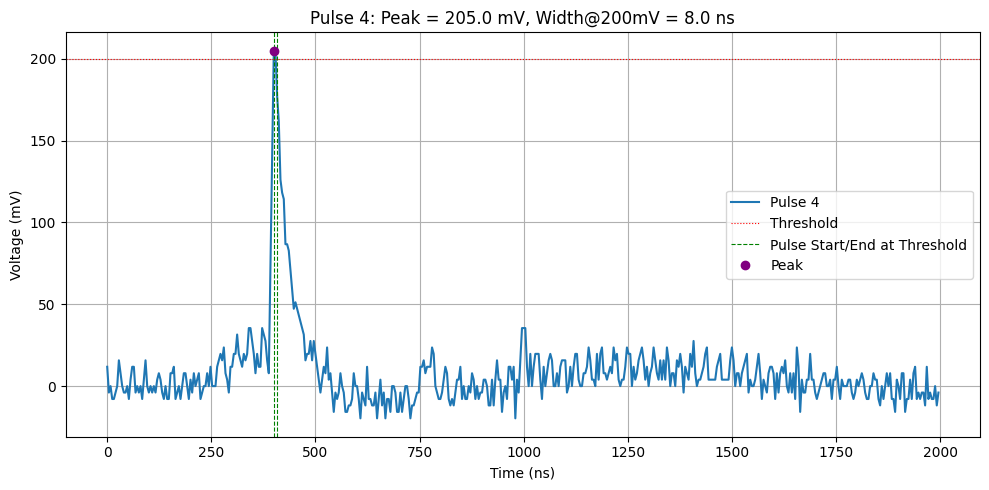

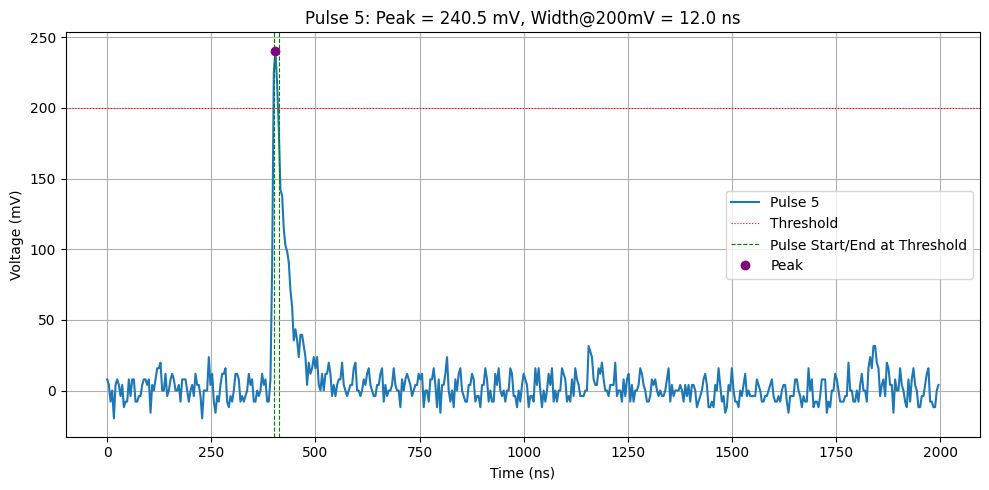

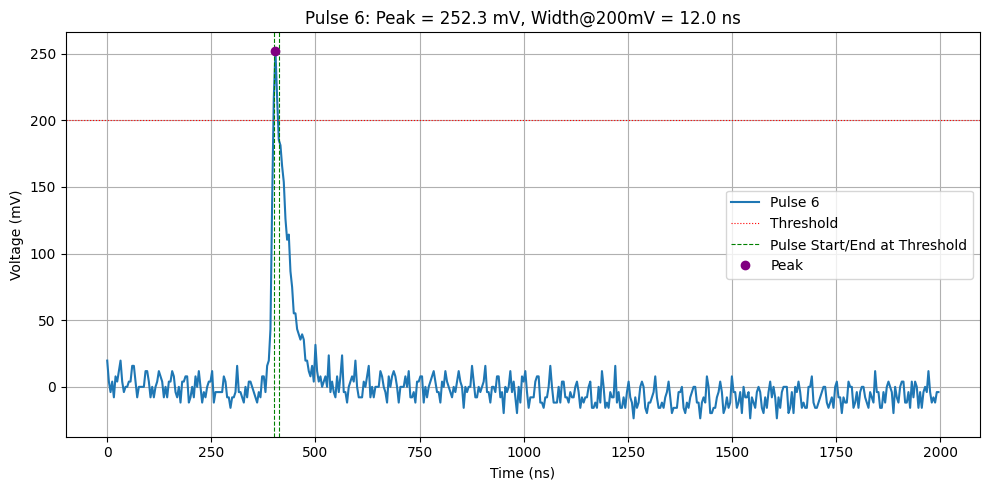

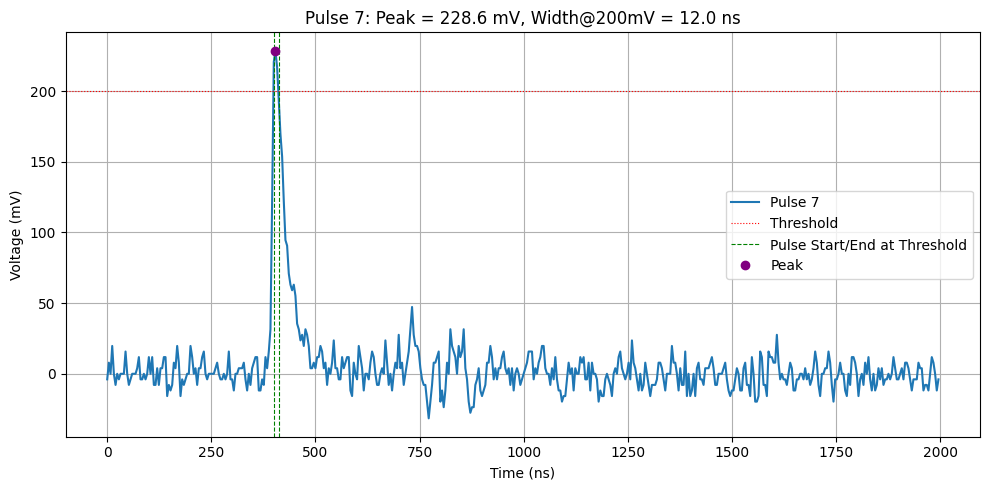

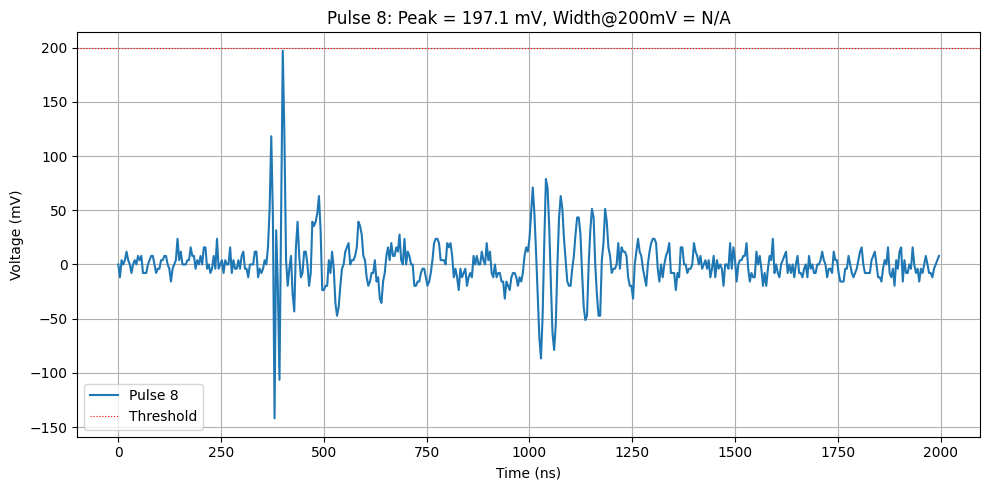

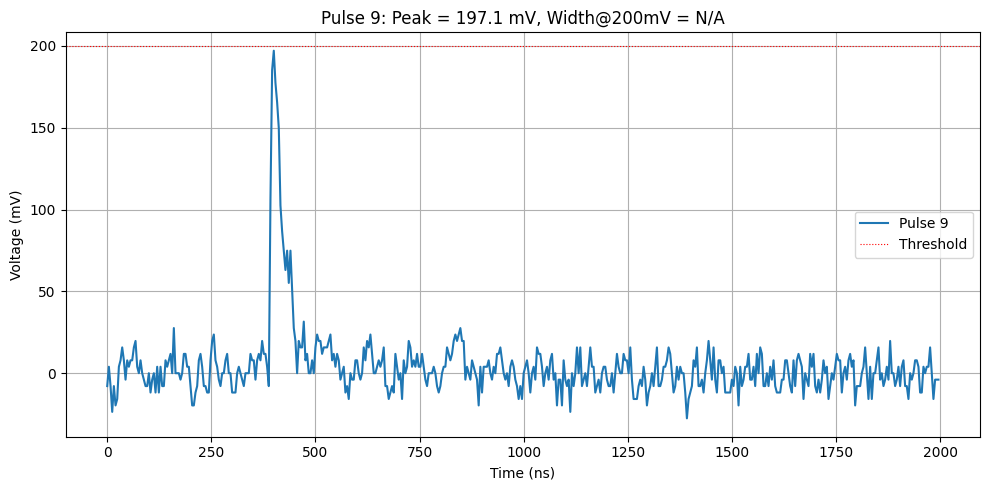

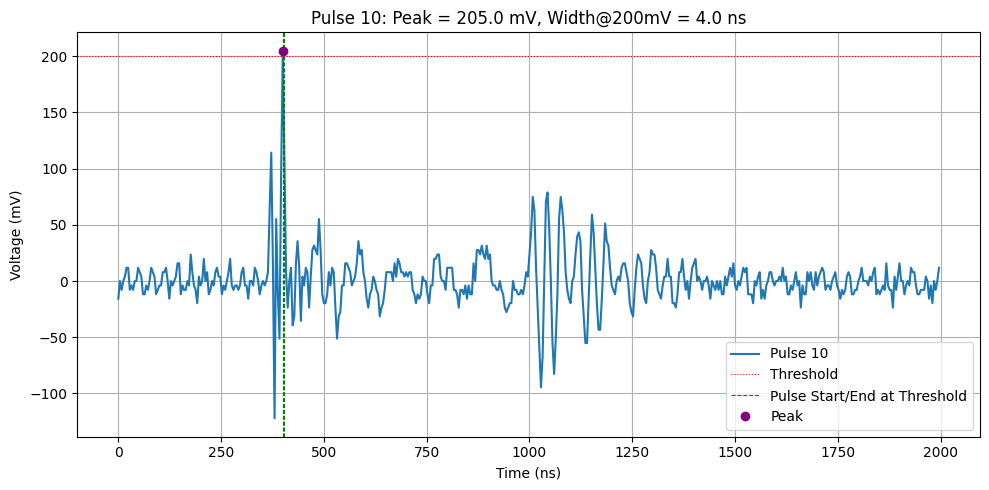


PicoScope unit closed.

Saved 24873 pulses with width in 20-50 ns range to sipm_amplitudes_pulse_width_filtered_676.csv


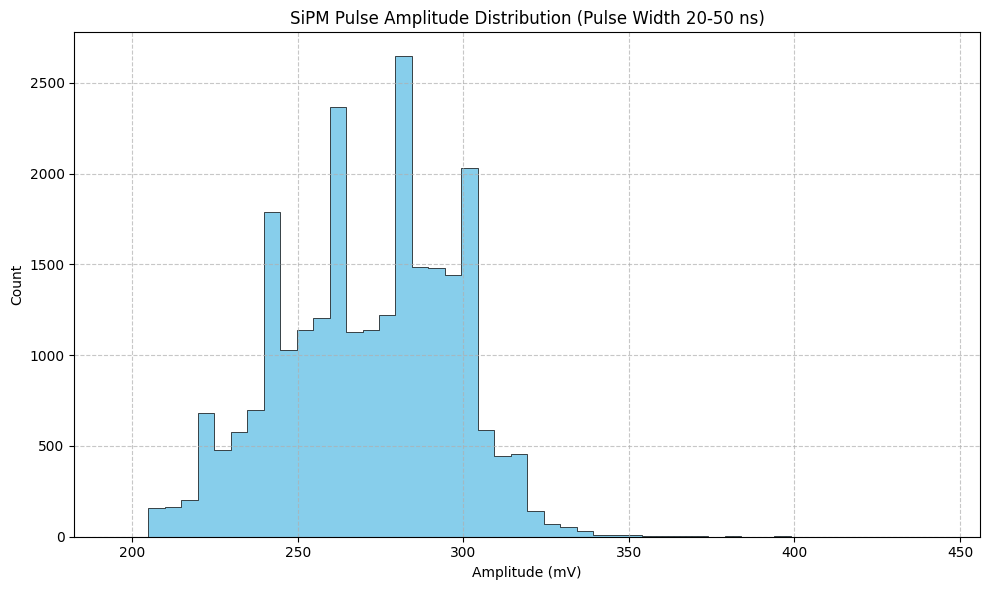

In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
from picosdk.ps2000a import ps2000a as ps
from picosdk.functions import adc2mV, assert_pico_ok

# === PARAMETERS ===
num_pulses_to_capture = 100000
threshold_mv = 200 # This threshold is for both trigger and pulse width measurement
voltage_range_mv = 500 # Use 500 for ±500mV. Make sure this matches the PicoScope range_code.
timebase = 1 # 2 ns/sample
num_samples = 500
pre_trigger_percent = 0.2 # 20% pre-trigger
# Filtering based on pulse width at threshold
pulse_width_min_ns = 20
pulse_width_max_ns = 50

amplitudes = []
waveform_buffers = [] # Stores raw waveforms for plotting
pulse_widths_filtered = [] # Stores pulse widths that pass the filter

# === CONNECT TO PICO ===
chandle = ctypes.c_int16()
status = ps.ps2000aOpenUnit(ctypes.byref(chandle), None)
assert_pico_ok(status)

# === CHANNEL SETUP ===
channel = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']
coupling = ps.PS2000A_COUPLING['PS2000A_DC']
# Ensure this range code matches your voltage_range_mv
# e.g., if voltage_range_mv = 500, use PS2000A_500MV
# If voltage_range_mv = 1000, use PS2000A_1V
if voltage_range_mv == 500:
    range_code = ps.PS2000A_RANGE['PS2000A_500MV']
elif voltage_range_mv == 1000:
    range_code = ps.PS2000A_RANGE['PS2000A_1V']
elif voltage_range_mv == 2000:
    range_code = ps.PS2000A_RANGE['PS2000A_2V']
else:
    raise ValueError(f"Unsupported voltage_range_mv: {voltage_range_mv}. Please add corresponding PS2000A_RANGE.")

offset_v = 0.0
status = ps.ps2000aSetChannel(chandle, channel, 1, coupling, range_code, offset_v)
assert_pico_ok(status)

# === ADC INFO ===
max_adc = ctypes.c_int16()
status = ps.ps2000aMaximumValue(chandle, ctypes.byref(max_adc))
assert_pico_ok(status)

# === TIMEBASE INFO ===
time_interval_ns = ctypes.c_float()
returned_max_samples = ctypes.c_int32()
# Get timebase information
# 0 for oversample
status = ps.ps2000aGetTimebase2(
    chandle, timebase, num_samples,
    ctypes.byref(time_interval_ns), 0,
    ctypes.byref(returned_max_samples), 0
)
assert_pico_ok(status)
print(f"Time interval: {time_interval_ns.value:.2f} ns/sample")

# === TRIGGER SETUP ===
# Convert threshold from mV to ADC counts
# Assuming positive pulses based on previous discussions
threshold_adc = int(threshold_mv * max_adc.value / voltage_range_mv)
status = ps.ps2000aSetSimpleTrigger(
    chandle, 1, channel, threshold_adc,
    ps.PS2000A_THRESHOLD_DIRECTION['PS2000A_RISING'], # Trigger on rising edge
    0, # Delay
    1000 # auto_trigger_ms
)
assert_pico_ok(status)

# === PULSE WIDTH AT THRESHOLD FUNCTION ===
def compute_pulse_width_at_threshold(time_ns, voltages_mv, threshold, pulse_polarity='positive'):
    """
    Computes the width of a pulse from the first time it crosses the threshold
    to the first time it drops below the threshold after its peak.

    Args:
        time_ns (np.array): Time axis in nanoseconds.
        voltages_mv (np.array): Voltage trace in mV.
        threshold (float): The voltage threshold in mV.
        pulse_polarity (str): 'positive' or 'negative' pulse.

    Returns:
        tuple: (pulse_width_ns, start_idx, end_idx, peak_amplitude_mv)
               Returns (None, None, None, None) if pulse cannot be characterized.
    """
    if pulse_polarity == 'negative':
        # Invert for processing, then convert back for results
        voltages_mv = -voltages_mv
        threshold = -threshold # Adjust threshold for inverted trace

    # Find where the signal first crosses the threshold on the rising edge
    # This assumes the trigger already ensured it crossed the threshold
    rising_crossings = np.where(voltages_mv >= threshold)[0]
    
    if len(rising_crossings) == 0:
        return None, None, None, None # No part of the pulse is above threshold

    # Find the index of the true peak within the region above threshold
    # Start looking from the first rising crossing point
    start_search_idx = rising_crossings[0]
    
    # Find the peak after the initial threshold crossing
    # Limit search to avoid going too far or picking up noise
    # A simple approach: find the peak within a reasonable window after crossing
    # A more robust approach might be to find local maxima within the full trace
    # For now, let's assume the trigger point is good enough to find the peak nearby
    
    # Find the true peak of the pulse (absolute max in the entire trace)
    # This might need refinement if there are multiple "pulses" in one capture
    peak_idx = np.argmax(voltages_mv)
    peak_amplitude_mv = voltages_mv[peak_idx]

    # Ensure the peak is above the threshold
    if peak_amplitude_mv < threshold:
        return None, None, None, None

    # Find the first point where the signal drops below the threshold *after* the peak
    falling_crossings = np.where(voltages_mv[peak_idx:] < threshold)[0]
    
    if len(falling_crossings) == 0:
        # Pulse doesn't fall below threshold within the captured window after peak
        # Or, the pulse is still above threshold at the end of the capture
        return None, None, None, None 
    
    # The index in the full trace where the falling edge crosses the threshold
    end_idx = peak_idx + falling_crossings[0]
    
    # The actual start index: find the first time it crossed threshold before the peak
    # Search backwards from the peak for the first crossing point
    start_idx_candidates = np.where(voltages_mv[:peak_idx] < threshold)[0]
    if len(start_idx_candidates) > 0:
        start_idx = start_idx_candidates[-1] + 1 # First point >= threshold
    else:
        start_idx = 0 # Pulse starts above threshold from beginning of trace

    # Recalculate if start_idx came AFTER peak (shouldn't happen with good data/trigger)
    if start_idx >= peak_idx:
        start_idx = np.where(voltages_mv >= threshold)[0][0] if len(np.where(voltages_mv >= threshold)[0]) > 0 else 0


    # Check if start_idx is before end_idx and both are valid
    if start_idx >= end_idx:
        return None, None, None, None # Invalid pulse shape (e.g., peak at start/end)

    pulse_width_ns = time_ns[end_idx] - time_ns[start_idx]

    # Convert peak amplitude back if polarity was negative
    if pulse_polarity == 'negative':
        peak_amplitude_mv = -peak_amplitude_mv

    return pulse_width_ns, start_idx, end_idx, peak_amplitude_mv


# === CAPTURE LOOP ===
pre_trigger_samples = int(pre_trigger_percent * num_samples)
post_trigger_samples = num_samples - pre_trigger_samples

for i in range(num_pulses_to_capture):
    print(f"Capturing pulse {i+1}/{num_pulses_to_capture}...")

    buffer = (ctypes.c_int16 * num_samples)()
    status = ps.ps2000aSetDataBuffers(chandle, channel, buffer, None, num_samples, 0, 0)
    assert_pico_ok(status)

    status = ps.ps2000aRunBlock(
        chandle,
        pre_trigger_samples,
        post_trigger_samples,
        timebase,
        0, # segmentIndex
        None, # lpReady
        0, # pParameter
        None, # lpReadyCallback
        None # pContext
    )
    assert_pico_ok(status)

    ready = ctypes.c_int16(0)
    while not ready.value:
        status = ps.ps2000aIsReady(chandle, ctypes.byref(ready))
        assert_pico_ok(status)
        if not ready.value:
            time.sleep(0.001)

    c_samples = ctypes.c_int32(num_samples)
    overflow = ctypes.c_int16()
    status = ps.ps2000aGetValues(chandle, 0, ctypes.byref(c_samples), 0, 0, 0, ctypes.byref(overflow))
    assert_pico_ok(status)

    voltages_mv =np.array(adc2mV(buffer, range_code, max_adc))
    
    # Store raw waveform for initial plotting of a few pulses
    # Only store a few to avoid excessive memory usage
    if len(waveform_buffers) < 10: # Store up to 10 for visualization
        waveform_buffers.append(voltages_mv)

    # Calculate pulse width at threshold
    time_axis_ns = np.arange(num_samples) * time_interval_ns.value
    
    pulse_width_ns, start_idx, end_idx, peak_amplitude = compute_pulse_width_at_threshold(
        time_axis_ns, voltages_mv, threshold_mv, pulse_polarity='positive'
    )

    if pulse_width_ns is not None:
        if pulse_width_min_ns <= pulse_width_ns <= pulse_width_max_ns:
            amplitudes.append(peak_amplitude)
            pulse_widths_filtered.append(pulse_width_ns)
            # print(f"  Pulse accepted: Width={pulse_width_ns:.1f} ns, Peak={peak_amplitude:.1f} mV")
        # else:
        #     print(f"  Pulse rejected (width out of range): Width={pulse_width_ns:.1f} ns, Peak={peak_amplitude:.1f} mV")
    # else:
    #     print(f"  Pulse rejected (could not characterize).")

    ps.ps2000aStop(chandle)

# === PLOT FIRST FEW CAPTURED PULSES (with new pulse width visualization) ===
print("\nPlotting example pulses...")
for i, voltages_mv in enumerate(waveform_buffers): # Iterate through the stored raw waveforms
    time_axis_ns = np.arange(num_samples) * time_interval_ns.value
    pulse_width_ns, start_idx, end_idx, peak_amplitude = compute_pulse_width_at_threshold(
        time_axis_ns, voltages_mv, threshold_mv, pulse_polarity='positive'
    )

    plt.figure(figsize=(10, 5))
    plt.plot(time_axis_ns, voltages_mv, label=f'Pulse {i+1}')
    plt.axhline(threshold_mv, color='red', linestyle=':', linewidth=0.8, label='Threshold')

    if pulse_width_ns is not None:
        plt.axvline(time_axis_ns[start_idx], color='green', linestyle='--', linewidth=0.8, label='Pulse Start/End at Threshold')
        plt.axvline(time_axis_ns[end_idx], color='green', linestyle='--', linewidth=0.8)
        plt.plot(time_axis_ns[np.argmax(voltages_mv)], peak_amplitude, 'o', color='purple', markersize=6, label='Peak')
        plt.title(f"Pulse {i+1}: Peak = {peak_amplitude:.1f} mV, Width@{threshold_mv}mV = {pulse_width_ns:.1f} ns")
    else:
        plt.title(f"Pulse {i+1}: Peak = {np.max(voltages_mv):.1f} mV, Width@{threshold_mv}mV = N/A")

    plt.xlabel("Time (ns)")
    plt.ylabel("Voltage (mV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === CLEANUP ===
ps.ps2000aCloseUnit(chandle)
print("\nPicoScope unit closed.")

# === SAVE TO CSV ===
filename = "sipm_amplitudes_pulse_width_filtered_676.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Amplitude_mV", "Pulse_Width_ns"])
    for amp, width in zip(amplitudes, pulse_widths_filtered):
        writer.writerow([amp, width])
print(f"\nSaved {len(amplitudes)} pulses with width in {pulse_width_min_ns}-{pulse_width_max_ns} ns range to {filename}")

# === HISTOGRAM ===
if len(amplitudes) > 0:
    bin_edges = np.linspace(np.min(amplitudes) - 10, np.max(amplitudes) + 10, 51)
    plt.figure(figsize=(10, 6))
    plt.hist(amplitudes, bins=bin_edges, histtype='stepfilled',
             color='skyblue', edgecolor='black', linewidth=0.5)

    plt.title(f"SiPM Pulse Amplitude Distribution (Pulse Width {pulse_width_min_ns}-{pulse_width_max_ns} ns)")
    plt.xlabel("Amplitude (mV)")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo pulses passed the filter to plot the histogram.")

Successfully loaded 24873 amplitudes from sipm_amplitudes_pulse_width_filtered_676.csv


<Figure size 1000x600 with 0 Axes>

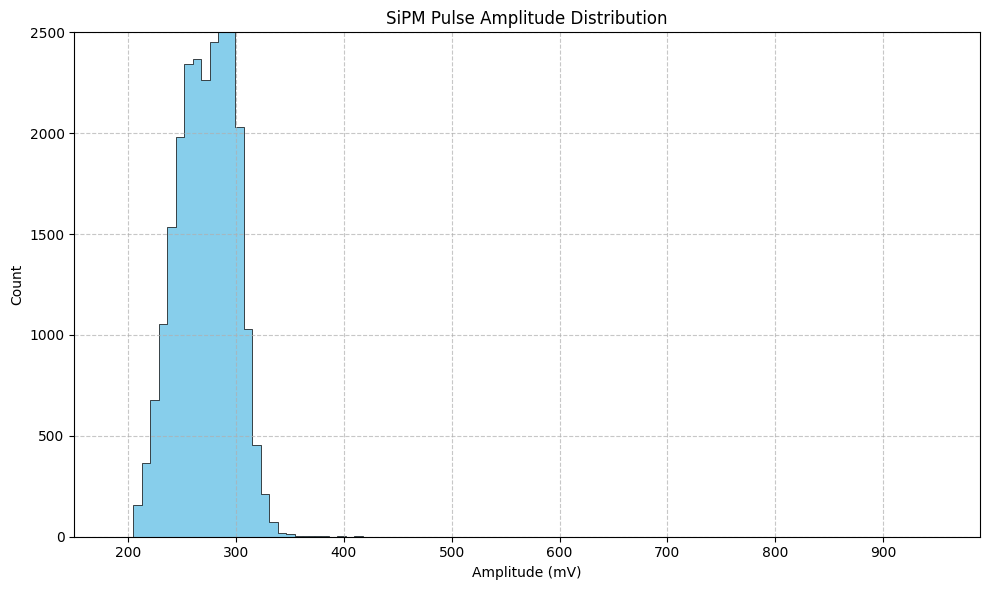

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

# === CONFIGURATION ===
# Define the filename where your recorded amplitudes are stored
filename = "sipm_amplitudes_pulse_width_filtered_676.csv"

# === LOAD DATA FROM CSV ===
amplitudes = []
try:
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        header = next(reader) # Skip the header row
        if "Amplitude_mV" not in header:
            print(f"Warning: Expected 'Amplitude_mV' column in {filename}, but found: {header}")
            # Attempt to read the first column if header doesn't match exactly
            # This is a fallback, ideally the header should match.
            for row in reader:
                try:
                    amplitudes.append(float(row[0]))
                except (ValueError, IndexError):
                    print(f"Skipping malformed row: {row}")
                    continue
        else:
            # Find the index of the 'Amplitude_mV' column
            amplitude_col_index = header.index("Amplitude_mV")
            for row in reader:
                try:
                    amplitudes.append(float(row[amplitude_col_index]))
                except (ValueError, IndexError):
                    print(f"Skipping malformed row: {row}")
                    continue
    print(f"Successfully loaded {len(amplitudes)} amplitudes from {filename}")

except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found. Please ensure it's in the same directory as this script.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")
    exit()

if not amplitudes:
    print("No amplitude data found in the file to plot. Exiting.")
    exit()

# Convert to numpy array for easier manipulation
amplitudes = np.array(amplitudes)

# === PLOT HISTOGRAM ===
plt.figure(figsize=(10, 6))

# Determine a suitable number of bins.
# You can adjust this value. A common rule of thumb is sqrt(N) or N^(1/3),
# or simply a fixed large number like 100 or 200 for high resolution.
# Let's use a fixed number for clarity, or you can calculate it:
# num_bins = int(np.sqrt(len(amplitudes))) # Example: sqrt(N)
# num_bins = int(len(amplitudes)**(1/3) * 2) # Example: N^(1/3) rule, adjusted
num_bins = int(np.round(2**8/2)) # A good number to start with for "a lot of bins"

# === PLOT HISTOGRAM ===
bin_edges = np.linspace(0, 1000, num_bins)  # 100 bins of 1 mV width

plt.figure(figsize=(10, 6))
plt.hist(amplitudes, bins=bin_edges, histtype='stepfilled',
         color='skyblue', edgecolor='black', linewidth=0.5)

plt.title("SiPM Pulse Amplitude Distribution")
plt.xlabel("Amplitude (mV)")
plt.xlim(150,990)
plt.ylim(0,2500)
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


PicoScope 2000A device connected successfully.
Acquisition duration: 0.05 seconds
Target sampling rate: 500 MS/s
Voltage range: +/- 1000 mV
Threshold: 300 mV
Number of pulses above threshold: 43
Estimated Dark Count Rate (DCR): 860.00 Hz


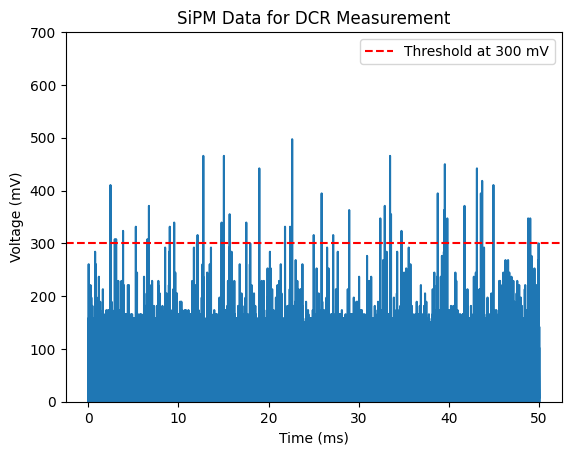

In [41]:
import ctypes
import numpy as np
from picosdk.ps2000a import ps2000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico_ok
import time

def check_picoscope_connection():
    """Checks if a PicoScope 2000A device can be opened."""
    chandle = ctypes.c_int16()
    try:
        status = ps.ps2000aOpenUnit(ctypes.byref(chandle), None)
        assert_pico_ok(status)
        if status == 0:
            print("PicoScope 2000A device connected successfully.")
            return chandle
        else:
            print(f"PicoScope 2000A device connection failed. Status code: {status}")
            return None
    except Exception as e:
        print(f"Error connecting to PicoScope 2000A: {e}")
        return None

def setup_channel(chandle, channel, enabled, coupling, range_mv, offset_v=0.0):
    """Sets up a PicoScope channel."""
    range_code = None
    ranges_mv = {
        10: ps.PS2000A_RANGE['PS2000A_10MV'],
        20: ps.PS2000A_RANGE['PS2000A_20MV'],
        50: ps.PS2000A_RANGE['PS2000A_50MV'],
        100: ps.PS2000A_RANGE['PS2000A_100MV'],
        200: ps.PS2000A_RANGE['PS2000A_200MV'],
        500: ps.PS2000A_RANGE['PS2000A_500MV'],
        1000: ps.PS2000A_RANGE['PS2000A_1V'],
        2000: ps.PS2000A_RANGE['PS2000A_2V'],
        5000: ps.PS2000A_RANGE['PS2000A_5V'],
        10000: ps.PS2000A_RANGE['PS2000A_10V'],
        20000: ps.PS2000A_RANGE['PS2000A_20V']
    }
    if range_mv in ranges_mv:
        range_code = ranges_mv[range_mv]
    else:
        print(f"Warning: {range_mv} mV range not directly supported. Using closest available.")
        closest_range = min(ranges_mv.keys(), key=lambda x: abs(x - range_mv))
        range_code = ranges_mv[closest_range]
        range_mv = closest_range
        print(f"Using {range_mv} mV range (code: {range_code}).")

    status = ps.ps2000aSetChannel(chandle,
                                   channel,
                                   enabled,
                                   coupling,
                                   range_code,
                                   offset_v)
    assert_pico_ok(status)
    return range_code, range_mv
def acquire_block_data(chandle, num_samples, timebase):
    """Acquires a block of data from the PicoScope."""
    buffer_max = (ctypes.c_int16 * num_samples)()
    buffer_min = (ctypes.c_int16 * num_samples)()
    channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']

    status_set_buffers = ps.ps2000aSetDataBuffers(chandle, channel_a, ctypes.byref(buffer_max), ctypes.byref(buffer_min), num_samples, 0, 0)
    assert_pico_ok(status_set_buffers)

    status_run_block = ps.ps2000aRunBlock(chandle, 0, num_samples, timebase, 0, None, 0, None, None)
    assert_pico_ok(status_run_block)

    ready = ctypes.c_int16(0)
    check = ctypes.c_int16(0)
    while ready.value == check.value:
        is_ready = ps.ps2000aIsReady(chandle, ctypes.byref(ready))
        if is_ready != 0:  # Handle potential errors from IsReady
            print(f"Error checking readiness: {is_ready}")
            break
        time.sleep(0.001)

    overflow = ctypes.c_int16()
    c_num_samples = ctypes.c_int32(num_samples)
    status_get_values = ps.ps2000aGetValues(chandle, 0, ctypes.byref(c_num_samples), 0, 0, 0, ctypes.byref(overflow))
    assert_pico_ok(status_get_values)

    return buffer_max

def count_pulses(voltage_data_mv, threshold_mv):
    """Counts the number of pulses that cross a positive threshold."""
    crossings = 0
    above_threshold = False
    for i in range(1, len(voltage_data_mv)):
        if voltage_data_mv[i] > threshold_mv and not above_threshold:
            crossings += 1
            above_threshold = True
        elif voltage_data_mv[i] < threshold_mv:
            above_threshold = False
    return crossings

def main():
    """Measures DCR of a SiPM using a threshold with PicoScope 2000A."""
    chandle = check_picoscope_connection()
    if chandle is None:
        return

    channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']
    enabled = 1
    coupling = ps.PS2000A_COUPLING['PS2000A_DC']
    voltage_range_mv = 1000
    threshold_mv = 300
    
    acquisition_duration_s = 0.05


    # Determine the timebase for approximately 500 MS/s
    # Consult the PicoScope 2000A Programmer's Guide!
    # A timebase of 2 often corresponds to a 2 ns sampling interval (500 MS/s).
    timebase = 1

    # Calculate the number of samples
    time_interval_ns = ctypes.c_float()
    returned_max_samples = ctypes.c_int32()
    oversample = ctypes.c_int16(0)
    status_tb = ps.ps2000aGetTimebase2(chandle, timebase, 1, ctypes.byref(time_interval_ns), oversample, ctypes.byref(returned_max_samples), 0)
    assert_pico_ok(status_tb)
    sampling_interval_s = time_interval_ns.value / 1e9
    num_samples = int(acquisition_duration_s / sampling_interval_s)

    try:
        channel_range_code, actual_range_mv = setup_channel(chandle, channel_a, enabled, coupling, voltage_range_mv)

        buffer_a_adc = acquire_block_data(chandle, num_samples, timebase)

        maxADC = ctypes.c_int16()
        status_max_adc = ps.ps2000aMaximumValue(chandle, ctypes.byref(maxADC))
        assert_pico_ok(status_max_adc)

        voltage_data_mv = adc2mV(buffer_a_adc, channel_range_code, maxADC)
        num_pulses = count_pulses(voltage_data_mv, threshold_mv)
        dark_count_rate = num_pulses / acquisition_duration_s

        time_data_s = np.linspace(0, acquisition_duration_s, num_samples)
        time_data_ms = time_data_s * 1e3

        print(f"Acquisition duration: {acquisition_duration_s} seconds")
        print(f"Target sampling rate: 500 MS/s")
        print(f"Voltage range: +/- {actual_range_mv} mV")
        print(f"Threshold: {threshold_mv} mV")
        print(f"Number of pulses above threshold: {num_pulses}")
        print(f"Estimated Dark Count Rate (DCR): {dark_count_rate:.2f} Hz")

        plt.plot(time_data_ms, voltage_data_mv)
        plt.ylim(0,700)
        plt.axhline(y=threshold_mv, color='r', linestyle='--', label=f'Threshold at {threshold_mv} mV')
        plt.xlabel('Time (ms)')
        #plt.xlim(0.6,0.6001)
        plt.ylabel('Voltage (mV)')
        plt.title('SiPM Data for DCR Measurement')
        plt.legend(loc = 'upper right')
        plt.show()

    finally:
        if chandle:
            status_close = ps.ps2000aCloseUnit(chandle)
            assert_pico_ok(status_close)

if __name__ == '__main__':
    main()

In [34]:
import ctypes
import numpy as np
from picosdk.ps2000a import ps2000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico_ok
import time
import serial
import csv
import os
import datetime
import scipy.stats

# --- Your existing helper functions (check_picoscope_connection, setup_channel, etc.) ---
# (Keep these as they are, they are well-defined and reusable)

def check_picoscope_connection():
    """Checks if a PicoScope 2000A device can be opened."""
    chandle = ctypes.c_int16()
    try:
        status = ps.ps2000aOpenUnit(ctypes.byref(chandle), None)
        assert_pico_ok(status)
        if status == 0:
            print("PicoScope 2000A device connected successfully.")
            return chandle
        else:
            print(f"PicoScope 2000A device connection failed. Status code: {status}")
            return None
    except Exception as e:
        print(f"Error connecting to PicoScope 2000A: {e}")
        return None

def setup_channel(chandle, channel, enabled, coupling, range_mv, offset_v=0.0):
    """Sets up a PicoScope channel."""
    range_code = None
    ranges_mv = {
        10: ps.PS2000A_RANGE['PS2000A_10MV'],
        20: ps.PS2000A_RANGE['PS2000A_20MV'],
        50: ps.PS2000A_RANGE['PS2000A_50MV'],
        100: ps.PS2000A_RANGE['PS2000A_100MV'],
        200: ps.PS2000A_RANGE['PS2000A_200MV'],
        500: ps.PS2000A_RANGE['PS2000A_500MV'],
        1000: ps.PS2000A_RANGE['PS2000A_1V'],
        2000: ps.PS2000A_RANGE['PS2000A_2V'],
        5000: ps.PS2000A_RANGE['PS2000A_5V'],
        10000: ps.PS2000A_RANGE['PS2000A_10V'],
        20000: ps.PS2000A_RANGE['PS2000A_20V']
    }
    if range_mv in ranges_mv:
        range_code = ranges_mv[range_mv]
    else:
        print(f"Warning: {range_mv} mV range not directly supported. Using closest available.")
        closest_range = min(ranges_mv.keys(), key=lambda x: abs(x - range_mv))
        range_code = ranges_mv[closest_range]
        range_mv = closest_range
        print(f"Using {range_mv} mV range (code: {range_code}).")

    status = ps.ps2000aSetChannel(chandle,
                                     channel,
                                     enabled,
                                     coupling,
                                     range_code,
                                     offset_v)
    assert_pico_ok(status)
    return range_code, range_mv

def acquire_block_data(chandle, num_samples, timebase):
    """Acquires a block of data from the PicoScope."""
    buffer_max = (ctypes.c_int16 * num_samples)()
    buffer_min = (ctypes.c_int16 * num_samples)()
    channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']

    status_set_buffers = ps.ps2000aSetDataBuffers(chandle, channel_a, ctypes.byref(buffer_max), ctypes.byref(buffer_min), num_samples, 0, 0)
    assert_pico_ok(status_set_buffers)

    status_run_block = ps.ps2000aRunBlock(chandle, 0, num_samples, timebase, 0, None, 0, None, None)
    assert_pico_ok(status_run_block)

    ready = ctypes.c_int16(0)
    check = ctypes.c_int16(0)
    while ready.value == check.value:
        is_ready = ps.ps2000aIsReady(chandle, ctypes.byref(ready))
        if is_ready != 0:
            print(f"Error checking readiness: {is_ready}")
            break
        time.sleep(0.001)

    overflow = ctypes.c_int16()
    c_num_samples = ctypes.c_int32(num_samples)
    status_get_values = ps.ps2000aGetValues(chandle, 0, ctypes.byref(c_num_samples), 0, 0, 0, ctypes.byref(overflow))
    assert_pico_ok(status_get_values)

    return buffer_max

def count_pulses(voltage_data_mv, threshold_mv):
    """Counts the number of pulses that cross a positive threshold."""
    crossings = 0
    # Simple edge detection: count when signal goes from below threshold to above.
    # This avoids counting multiple points within a single pulse if it stays high.
    above_threshold = False
    for val in voltage_data_mv:
        if val > threshold_mv and not above_threshold:
            crossings += 1
            above_threshold = True
        elif val < threshold_mv: # Reset flag when signal goes below threshold
            above_threshold = False
    return crossings

def connect_plh120p(port, baudrate=9600, timeout=2):
    """Connect to the PLH120P power supply."""
    try:
        ser = serial.Serial(port, baudrate, timeout=timeout)
        print(f"Connected to PLH120 P on port {port} with baudrate {baudrate}.")
        return ser
    except serial.SerialException as e:
        print(f"Error: {e}")
        print(
            f"Could not connect to PLH120 P on port {port}. Please ensure the device is "
            "connected, the port is correct, and no other program is using the port."
        )
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def send_command(ser, command):
    """Send a command to the PLH120P."""
    if ser:
        ser.write(f"{command}\r\n".encode("ascii"))

def set_voltage(ser, voltage):
    """Sets the voltage of the power supply."""
    if ser:
        send_command(ser, f"V1 {voltage:.2f}")
        time.sleep(0.1)

def turn_on_output(ser):
    """Turn the output on."""
    if ser:
        send_command(ser, "OP1 1")
        time.sleep(0.5)

def turn_off_output(ser):
    """Turn the output off."""
    if ser:
        send_command(ser, "OP1 0")

def measure_dcr(chandle, voltage_range_mv, threshold_mv, acquisition_duration_s=0.001, sampling_rate_hz=500e6):
    """Measures the Dark Count Rate for a given PicoScope handle and settings."""
    # Note: timebase calculation needs to be more robust for different sampling_rate_hz
    # For PS2000a, timebase is 0 (fastest) to 2^32-1 (slowest)
    # The actual time interval depends on the model. For 2000a, timebase 0 is 1.25ns.
    # timebase = int(np.log2(sampling_rate_hz * 1.25e-9)) # This is an approximation
    # For simplicity, using a fixed timebase that gives high sampling rate.
    
    # A more correct way to set timebase for a desired sampling rate:
    # timebase_index = round(np.log2(sampling_rate_hz * 1.25e-9) + 2) # Example for higher timebases
    # For very high sampling rates, timebase 0 or 1 is often fixed
    
    # Let's use a timebase that corresponds to 500MS/s if possible, or close to it.
    # Timebase 1 on a PS2000A is often 2ns/sample (500MS/s)
    # Check PicoScope 2000A programmer's guide for exact timebase values.
    
    # Assuming timebase 1 for 500 MS/s (2 ns/sample) as per typical 2000a specs
    timebase = 1 # Or calculate dynamically if you want to vary sampling_rate_hz more
    
    time_interval_ns = ctypes.c_float()
    returned_max_samples = ctypes.c_int32()
    oversample = ctypes.c_int16(0) # No oversampling for DCR
    
    # Get actual time interval and maximum samples for the chosen timebase
    status_tb = ps.ps2000aGetTimebase2(chandle, timebase, 0, ctypes.byref(time_interval_ns), oversample, ctypes.byref(returned_max_samples), 0)
    assert_pico_ok(status_tb)
    
    sampling_interval_s = time_interval_ns.value / 1e9
    num_samples = int(acquisition_duration_s / sampling_interval_s)
    
    # Ensure num_samples is at least 1 and does not exceed returned_max_samples
    num_samples = max(1, min(num_samples, returned_max_samples.value))
    
    channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']
    enabled = 1
    coupling = ps.PS2000A_COUPLING['PS2000A_DC']
    channel_range_code, actual_range_mv = setup_channel(chandle, channel_a, enabled, coupling, voltage_range_mv)

    buffer_a_adc = acquire_block_data(chandle, num_samples, timebase)

    maxADC = ctypes.c_int16()
    status_max_adc = ps.ps2000aMaximumValue(chandle, ctypes.byref(maxADC))
    assert_pico_ok(status_max_adc)

    voltage_data_mv = adc2mV(buffer_a_adc, channel_range_code, maxADC)
    
    # Count pulses
    num_pulses = count_pulses(voltage_data_mv, threshold_mv)
    
    # Calculate DCR
    dcr = num_pulses / acquisition_duration_s
    
    return dcr, actual_range_mv


def main_dcr_vs_threshold_and_voltage():
    """
    Measures DCR over a voltage range and a threshold range
    using PLH120P and PicoScope, with temperature handling.
    """
    pico_chandle = check_picoscope_connection()
    if pico_chandle is None:
        return

    plh_port = 'COM6'  # Replace with your PLH120P serial port
    plh_serial = connect_plh120p(plh_port)
    if plh_serial is None:
        ps.ps2000aCloseUnit(pico_chandle)
        return

    # --- Measurement Parameters ---
    voltage_range_mv_picoscope = 1000 # PicoScope input range (e.g., 200mV)
    
    # Define your threshold range
    # It's usually good to go from slightly above noise floor to well into the avalanche region
    threshold_min_mv = 250  # Example minimum threshold in mV
    threshold_max_mv = 550 # Example maximum threshold in mV
    threshold_step_mv = 50  # Step size for thresholds
    threshold_points = np.arange(threshold_min_mv, threshold_max_mv + threshold_step_mv, threshold_step_mv)
    
    num_runs = 10 # Number of measurements per (voltage, threshold) point
    acquisition_duration_s = 0.05 # Duration of each PicoScope acquisition

    # Define your voltage range for the power supply
    #voltage_points = np.arange(65, 70, 2) # Example voltage range
    voltage_points = [67]
    # Data structure to store all results
    # Each entry will be: [Timestamp, Temperature, Voltage, Avg DCR, SEM DCR, Threshold (mV)]
    all_dcr_results = []
    
    # Get temperature from the user (for this entire set of measurements)
    temperature = float(input("Enter the temperature in degrees Celsius for this measurement: "))
    csv_filename = f"dcr_vs_voltage_and_threshold_at_{temperature:.1f}C.csv" # Dynamic filename
    file_exists = os.path.isfile(csv_filename)

    # Initial power supply setup
    set_voltage(plh_serial, 60) # Set to first voltage point
    turn_on_output(plh_serial)
    time.sleep(2) # Allow power supply to stabilize

    try:
        for voltage in voltage_points:
            print(f"\n--- Setting power supply voltage to {voltage:.2f} V ---")
            set_voltage(plh_serial, voltage)
            time.sleep(2) # Allow voltage to settle on the SiPM

            for threshold_mv in threshold_points:
                print(f"Measuring DCR at Voltage: {voltage:.2f} V, Threshold: {threshold_mv:.1f} mV")
                dcr_values_for_point = []
                
                for i in range(num_runs):
                    dcr, actual_range_mv = measure_dcr(pico_chandle, voltage_range_mv_picoscope, threshold_mv, acquisition_duration_s)
                    dcr_values_for_point.append(dcr)
                    time.sleep(0.01) # Small delay between runs

                avg_dcr = np.mean(dcr_values_for_point)
                sem_dcr = scipy.stats.sem(dcr_values_for_point)
                
                print(f"  Avg DCR: {avg_dcr:.2f} Hz, SEM: {sem_dcr:.2f} Hz")
                
                timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                all_dcr_results.append([timestamp, temperature, voltage, avg_dcr, sem_dcr, threshold_mv])

        # Save all collected data to CSV
        with open(csv_filename, 'w', newline='') as csvfile: # Use 'w' to overwrite/create new file for this specific run
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Timestamp', 'Temperature (°C)', 'Voltage (V)', 'Average DCR (Hz)', 'SEM (Hz)', 'Threshold (mV)'])
            csv_writer.writerows(all_dcr_results)
        print(f"\nAll DCR vs. Voltage and Threshold data saved to {csv_filename}")

        # --- Plotting the Results ---
        # This part requires more thought on how to visualize.
        # Option 1: DCR vs. Threshold for each Voltage (separate lines)
        plt.figure(figsize=(10, 7))
        plt.yscale('log')
        plt.xlabel('Threshold (mV)')
        plt.ylabel('Average Dark Count Rate (Hz)')
        plt.title(f'DCR vs. Threshold at {temperature:.1f}°C')
        plt.grid(True)

        for voltage in voltage_points:
            # Filter data for current voltage
            data_for_voltage = [r for r in all_dcr_results if r[2] == voltage]
            
            # Sort by threshold for clean plotting
            data_for_voltage.sort(key=lambda x: x[5])
            
            thresholds = [r[5] for r in data_for_voltage]
            dcrs = [r[3] for r in data_for_voltage]
            sems = [r[4] for r in data_for_voltage]
            
            plt.errorbar(thresholds, dcrs, yerr=sems, fmt='o-', label=f'Voltage: {voltage:.2f}V', capsize=3)
        
        plt.legend(title='Applied Voltage')
        plt.tight_layout()
        plt.show()

        # Option 2: DCR vs. Overvoltage for each Threshold (separate plots or color-coded)
        # This requires V_BD calculation from previous steps.
        # For simplicity, I'm not integrating the V_BD fit here, as this measurement
        # is typically done at fixed temperature for an "ideal" characterization.
        # If you want to use overvoltage here, you'd need to pass the V_BD fit parameters.

    except Exception as e:
        print(f"An error occurred during the DCR sweep: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging
    finally:
        if pico_chandle:
            ps.ps2000aCloseUnit(pico_chandle)
            print("PicoScope closed.")
        if plh_serial:
            turn_off_output(plh_serial)
            plh_serial.close()
            print("Power supply closed.")

if __name__ == '__main__':
    main_dcr_vs_threshold_and_voltage()

PicoScope 2000A device connected successfully.
Connected to PLH120 P on port COM6 with baudrate 9600.

--- Setting power supply voltage to 67.00 V ---
Measuring DCR at Voltage: 67.00 V, Threshold: 250.0 mV
PicoScope closed.
Power supply closed.


KeyboardInterrupt: 

PicoScope 2000A device connected successfully.
Connected to PLH120 P on port COM6 with baudrate 9600.

Setting voltage to 64.00 V...
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...
  Run 6...
  Run 7...
  Average DCR at 64.00 V: 0.00 Hz, SEM: 0.00 Hz

Setting voltage to 64.20 V...
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...
  Run 6...
  Run 7...
  Average DCR at 64.20 V: 0.00 Hz, SEM: 0.00 Hz

Setting voltage to 64.40 V...
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...
  Run 6...
  Run 7...
  Average DCR at 64.40 V: 0.00 Hz, SEM: 0.00 Hz

Setting voltage to 64.60 V...
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...
  Run 6...
  Run 7...
  Average DCR at 64.60 V: 0.00 Hz, SEM: 0.00 Hz

Setting voltage to 64.80 V...
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...
  Run 6...
  Run 7...
  Average DCR at 64.80 V: 0.00 Hz, SEM: 0.00 Hz

Setting voltage to 65.00 V...
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...
  Run 6...
  Run 7...
  Average 

C:\Users\DBouc\AppData\Local\Temp\ipykernel_14956\1999691614.py:230: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


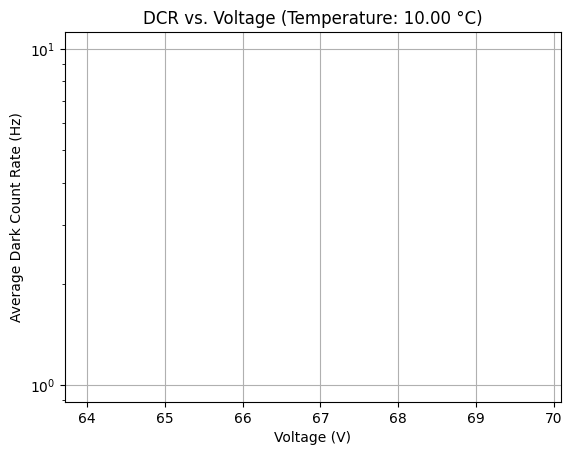

In [32]:
    import ctypes
    import numpy as np
    from picosdk.ps2000a import ps2000a as ps
    import matplotlib.pyplot as plt
    from picosdk.functions import adc2mV, assert_pico_ok
    import time
    import serial
    import csv
    import datetime  # Import datetime for timestamping
    import scipy.stats  # Import scipy.stats for calculating confidence intervals

    def check_picoscope_connection():
        """Checks if a PicoScope 2000A device can be opened."""
        chandle = ctypes.c_int16()
        try:
            status = ps.ps2000aOpenUnit(ctypes.byref(chandle), None)
            assert_pico_ok(status)
            if status == 0:
                print("PicoScope 2000A device connected successfully.")
                return chandle
            else:
                print(f"PicoScope 2000A device connection failed. Status code: {status}")
                return None
        except Exception as e:
            print(f"Error connecting to PicoScope 2000A: {e}")
            return None

    def setup_channel(chandle, channel, enabled, coupling, range_mv, offset_v=0.0):
        """Sets up a PicoScope channel."""
        range_code = None
        ranges_mv = {
            10: ps.PS2000A_RANGE['PS2000A_10MV'],
            20: ps.PS2000A_RANGE['PS2000A_20MV'],
            50: ps.PS2000A_RANGE['PS2000A_50MV'],
            100: ps.PS2000A_RANGE['PS2000A_100MV'],
            200: ps.PS2000A_RANGE['PS2000A_200MV'],
            500: ps.PS2000A_RANGE['PS2000A_500MV'],
            1000: ps.PS2000A_RANGE['PS2000A_1V'],
            2000: ps.PS2000A_RANGE['PS2000A_2V'],
            5000: ps.PS2000A_RANGE['PS2000A_5V'],
            10000: ps.PS2000A_RANGE['PS2000A_10V'],
            20000: ps.PS2000A_RANGE['PS2000A_20V']
        }
        if range_mv in ranges_mv:
            range_code = ranges_mv[range_mv]
        else:
            print(f"Warning: {range_mv} mV range not directly supported. Using closest available.")
            closest_range = min(ranges_mv.keys(), key=lambda x: abs(x - range_mv))
            range_code = ranges_mv[closest_range]
            range_mv = closest_range
            print(f"Using {range_mv} mV range (code: {range_code}).")

        status = ps.ps2000aSetChannel(chandle,
                                        channel,
                                        enabled,
                                        coupling,
                                        range_code,
                                        offset_v)
        assert_pico_ok(status)
        return range_code, range_mv

    def acquire_block_data(chandle, num_samples, timebase):
        """Acquires a block of data from the PicoScope."""
        buffer_max = (ctypes.c_int16 * num_samples)()
        buffer_min = (ctypes.c_int16 * num_samples)()
        channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']

        status_set_buffers = ps.ps2000aSetDataBuffers(chandle, channel_a, ctypes.byref(buffer_max), ctypes.byref(buffer_min), num_samples, 0, 0)
        assert_pico_ok(status_set_buffers)

        status_run_block = ps.ps2000aRunBlock(chandle, 0, num_samples, timebase, 0, None, 0, None, None)
        assert_pico_ok(status_run_block)

        ready = ctypes.c_int16(0)
        check = ctypes.c_int16(0)
        while ready.value == check.value:
            is_ready = ps.ps2000aIsReady(chandle, ctypes.byref(ready))
            if is_ready != 0:  # Handle potential errors from IsReady
                print(f"Error checking readiness: {is_ready}")
                break
            time.sleep(0.001)

        overflow = ctypes.c_int16()
        c_num_samples = ctypes.c_int32(num_samples)
        status_get_values = ps.ps2000aGetValues(chandle, 0, ctypes.byref(c_num_samples), 0, 0, 0, ctypes.byref(overflow))
        assert_pico_ok(status_get_values)

        return buffer_max

    def count_pulses(voltage_data_mv, threshold_mv):
        """Counts the number of pulses that cross a positive threshold."""
        crossings = 0
        above_threshold = False
        for i in range(1, len(voltage_data_mv)):
            if voltage_data_mv[i] > threshold_mv and not above_threshold:
                crossings += 1
                above_threshold = True
            elif voltage_data_mv[i] < threshold_mv:
                above_threshold = False
        return crossings

    def connect_plh120p(port, baudrate=9600, timeout=2):
        """Connect to the PLH120P power supply."""
        try:
            ser = serial.Serial(port, baudrate, timeout=timeout)
            print(f"Connected to PLH120 P on port {port} with baudrate {baudrate}.")
            return ser
        except serial.SerialException as e:
            print(f"Error: {e}")
            print(
                f"Could not connect to PLH120 P on port {port}. Please ensure the device is "
                "connected, the port is correct, and no other program is using the port."
            )
            return None
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            return None

    def send_command(ser, command):
        """Send a command to the PLH120P."""
        if ser:
            ser.write(f"{command}\r\n".encode("ascii"))

    def set_voltage(ser, voltage):
        """Sets the voltage of the power supply."""
        if ser:
            send_command(ser, f"V1 {voltage:.2f}")
            time.sleep(0.1)  # Small delay for voltage to settle

    def turn_on_output(ser):
        """Turn the output on."""
        if ser:
            send_command(ser, "OP1 1")
            time.sleep(0.5)  # Time for output to stabilize

    def turn_off_output(ser):
        """Turn the output off."""
        if ser:
            send_command(ser, "OP1 0")

    def measure_dcr(chandle, voltage_range_mv, threshold_mv, acquisition_duration_s=0.001, sampling_rate_hz=500e6):
        """Measures the Dark Count Rate for a given PicoScope handle and settings."""
        timebase = 1  # Assuming timebase 2 gives 500 MS/s, verify in your manual
        time_interval_ns = ctypes.c_float()
        returned_max_samples = ctypes.c_int32()
        oversample = ctypes.c_int16(0)
        status_tb = ps.ps2000aGetTimebase2(chandle, timebase, 1, ctypes.byref(time_interval_ns), oversample, ctypes.byref(returned_max_samples), 0)
        assert_pico_ok(status_tb)
        sampling_interval_s = time_interval_ns.value / 1e9
        num_samples = int(acquisition_duration_s / sampling_interval_s)

        channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']
        enabled = 1
        coupling = ps.PS2000A_COUPLING['PS2000A_DC']
        channel_range_code, actual_range_mv = setup_channel(chandle, channel_a, enabled, coupling, voltage_range_mv)

        buffer_a_adc = acquire_block_data(chandle, num_samples, timebase)

        maxADC = ctypes.c_int16()
        status_max_adc = ps.ps2000aMaximumValue(chandle, ctypes.byref(maxADC))
        assert_pico_ok(status_max_adc)

        voltage_data_mv = adc2mV(buffer_a_adc, channel_range_code, maxADC)
        num_pulses = count_pulses(voltage_data_mv, threshold_mv)
        dcr = num_pulses / acquisition_duration_s
        return dcr, actual_range_mv

    def main():
        """Measures DCR over a voltage range using PLH120P and PicoScope, with temperature handling."""
        pico_chandle = check_picoscope_connection()
        if pico_chandle is None:
            return

        plh_port = 'COM6'  # Replace with your PLH120P serial port
        plh_serial = connect_plh120p(plh_port)
        if plh_serial is None:
            ps.ps2000aCloseUnit(pico_chandle)
            return

        voltage_range_mv = 200
        threshold_mv = 300
        num_runs = 7
        acquisition_duration_s = 0.003
        voltage_points = np.arange(64, 70, 0.2)  # Example voltage range (adjust as needed)
        dcr_data = []
        set_voltage(plh_serial, 75)
        turn_on_output(plh_serial)

        # Get temperature from the user
        temperature = float(input("Enter the temperature in degrees Celsius: "))
        csv_filename = "dcr_vs_voltage3.csv"
        file_exists = os.path.isfile(csv_filename)  # Check if the file exists

        try:
            for voltage in voltage_points:
                print(f"\nSetting voltage to {voltage:.2f} V...")
                set_voltage(plh_serial, voltage)
                time.sleep(2)  # Allow voltage to stabilize

                dcr_values = []
                for i in range(num_runs):
                    print(f"  Run {i+1}...")
                    dcr, actual_range_mv = measure_dcr(pico_chandle, voltage_range_mv, threshold_mv, acquisition_duration_s)
                    dcr_values.append(dcr)
                    time.sleep(0.01)  # Small delay between runs

                avg_dcr = np.mean(dcr_values)
                sem = scipy.stats.sem(dcr_values)  # Calculate the standard error of the mean
                print(f"  Average DCR at {voltage:.2f} V: {avg_dcr:.2f} Hz, SEM: {sem:.2f} Hz")
                dcr_data.append([voltage, avg_dcr, sem])  # Store voltage, avg_dcr, and sem

            # Save data to CSV (append if file exists, create if it doesn't)
            with open(csv_filename, 'a', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
                if not file_exists:
                    csv_writer.writerow(['Timestamp', 'Temperature (°C)', 'Voltage (V)', 'Average DCR (Hz)', 'SEM (Hz)', 'Threshold (mV)'])  # Header row
                timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                for voltage, avg_dcr, sem in dcr_data:
                    csv_writer.writerow([timestamp, temperature, voltage, avg_dcr, sem, threshold_mv])
            print(f"Data saved to {csv_filename}")

            # Plotting
            voltages = [data[0] for data in dcr_data]
            dcr_values = [data[1] for data in dcr_data]
            sem_values = [data[2] for data in dcr_data]  # Get SEM values

            plt.figure()
            plt.errorbar(voltages, dcr_values, yerr=sem_values, fmt='o', capsize=5)  # Use errorbar
            plt.xlabel('Voltage (V)')
            plt.yscale('log')
            plt.ylabel('Average Dark Count Rate (Hz)')
            plt.title(f'DCR vs. Voltage (Temperature: {temperature:.2f} °C)')
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"An error occurred during the voltage sweep: {e}")
        finally:
            if pico_chandle:
                ps.ps2000aCloseUnit(pico_chandle)
            if plh_serial:
                turn_off_output(plh_serial)
                plh_serial.close()
    import os
    if __name__ == '__main__':
        import serial  # Import serial here to avoid issues if not installed initially
        main()


C:\Users\DBouc\AppData\Local\Temp\ipykernel_26500\2318065967.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


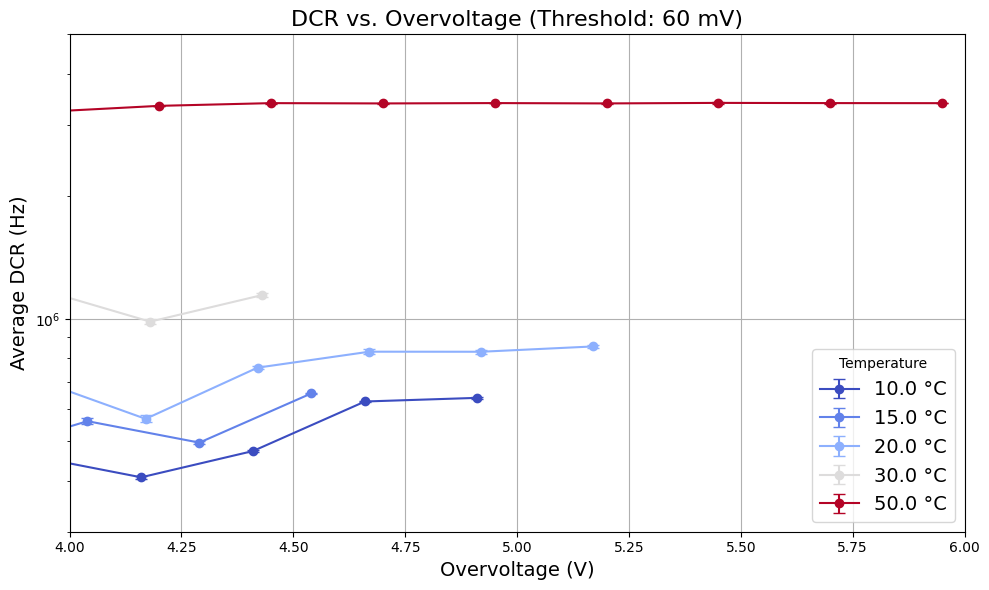

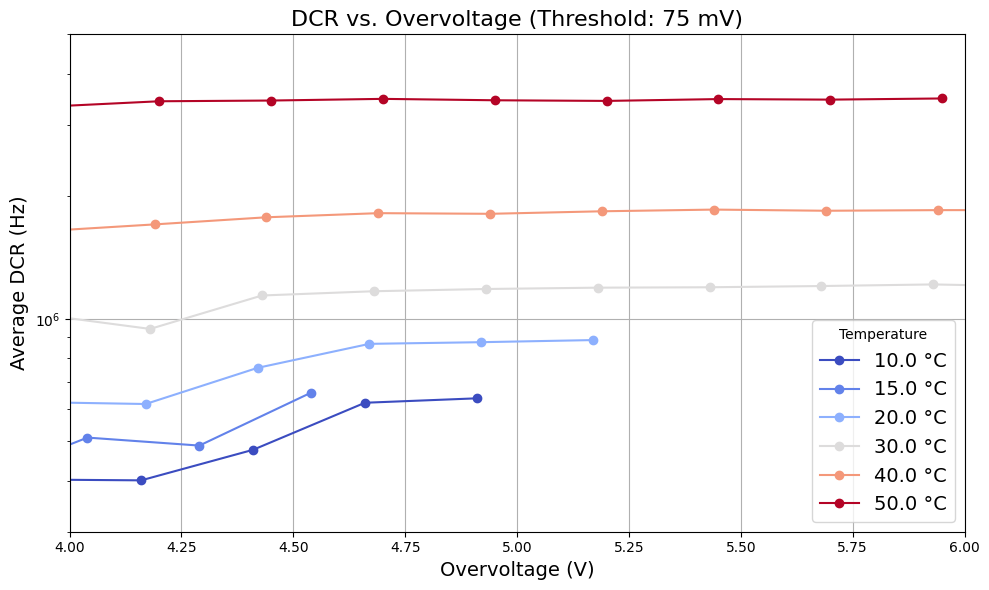

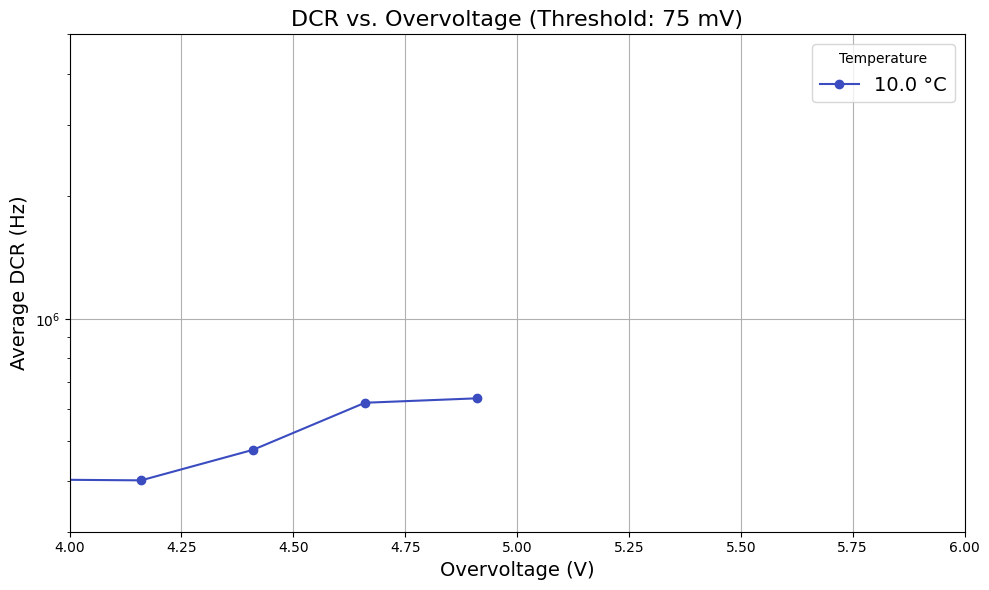

In [11]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def analyze_dcr_from_csv(csv_file, threshold_mv_filter=None, temperature_filter=None, show_errorbars=False):
    """
    Analyzes DCR data from a CSV file, generates DCR vs. Overvoltage plots with color-coded temperatures.
    Allows optional display of error bars if `show_errorbars` is True.

    Args:
        csv_file (str): Path to the CSV file.
        threshold_mv_filter (float, optional): Filters data by threshold voltage if set.
        temperature_filter (list of float, optional): List of specific temperatures to include.
        show_errorbars (bool, optional): Whether to show error bars (default: False).
    """
    dcr_values = {}
    sem_values = {}
    temperatures = set()
    voltages = set()

    with open(csv_file, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            try:
                temperature = float(row['Temperature (°C)'])
                voltage = float(row['Voltage (V)'])
                dcr = float(row['Average DCR (Hz)'])
                # Check if SEM data exists, if not, skip SEM processing
                sem = float(row['SEM (Hz)']) if 'SEM (Hz)' in row else None
                threshold = float(row['Threshold (mV)'])

                if (threshold_mv_filter is not None and threshold != threshold_mv_filter):
                    continue
                if (temperature_filter is not None and temperature not in temperature_filter):
                    continue

                temperatures.add(temperature)
                voltages.add(voltage)
                dcr_values[(temperature, voltage)] = dcr
                sem_values[(temperature, voltage)] = sem

            except ValueError as e:
                print(f"Skipping row due to error: {e}")

    if not dcr_values:
        print("No valid data found.")
        return

    # Sort for consistency
    temperatures = sorted(temperatures)
    voltages = sorted(voltages)

    # Color mapping
    norm = mcolors.Normalize(vmin=min(temperatures), vmax=max(temperatures))
    colormap = cm.get_cmap('coolwarm')

    # Plot DCR vs Overvoltage
    plt.figure(figsize=(10, 6))
    for temp in temperatures:
        v_bd = 63.1 + 0.074 * temp
        overvoltages = []
        dcr_at_temp = []
        sem_at_temp = []

        for v in voltages:
            key = (temp, v)
            if key in dcr_values:
                overvolt = v - v_bd
                overvoltages.append(overvolt)
                dcr_at_temp.append(dcr_values[key])
                sem_at_temp.append(sem_values.get(key))  # use get() to handle missing SEM

        if overvoltages:
            color = colormap(norm(temp))

            # Only show error bars if show_errorbars is True and SEM exists
            if show_errorbars and None not in sem_at_temp:
                plt.errorbar(overvoltages, dcr_at_temp, yerr=sem_at_temp,
                             fmt='o-', label=f'{temp:.1f} °C', capsize=4, color=color)
            else:
                plt.plot(overvoltages, dcr_at_temp, 'o-', label=f'{temp:.1f} °C', color=color)

    # Set axis labels with custom font size
    plt.xlabel('Overvoltage (V)', fontsize=14)
    plt.ylabel('Average DCR (Hz)', fontsize=14)
    plt.xlim(4, 6)
    plt.ylim(3*10E4, 5*10E5)
    plt.title(f'DCR vs. Overvoltage (Threshold: {threshold_mv_filter if threshold_mv_filter else "All"} mV)', fontsize=16)
    plt.yscale('log')
    plt.grid(True)
    plt.legend(title='Temperature', fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    csv_file_path = 'dcr_vs_voltage4.csv'  # Replace with your actual file

    # Example 1: Show error bars (with SEM data)
    analyze_dcr_from_csv(csv_file_path, threshold_mv_filter=60, temperature_filter=[10, 15, 20, 30, 40, 50], show_errorbars=True)

    # Example 2: Do not show error bars (no SEM data available)
    analyze_dcr_from_csv(csv_file_path, threshold_mv_filter=75, temperature_filter=[10, 15, 20, 30, 40, 50], show_errorbars=False)

    # Example 3: Specific temperature filter with no error bars
    analyze_dcr_from_csv(csv_file_path, threshold_mv_filter=75, temperature_filter=[10.0], show_errorbars=False)
